## Sanity Checking Our Expected Goals Models and Final Thoughts

In [1]:
import FCPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

The following lines of code allows us to view entire dataframes (or extremely large amounts of it) when called, thus making our lives a bit easier

In [2]:
pd.set_option("display.max_columns", 100000)
pd.set_option("display.max_colwidth", 20000000)
pd.set_option("display.width", 100000000)

Next, we run the same code from the previous notebook to set up our two models

In [3]:
shots_model = pd.read_csv('shots_design_matrix.csv')
shots_model = shots_model[shots_model['Distance']<75]
y=shots_model['Goal']
x_rf=shots_model.drop(['Goal', 'Unnamed: 0', 'firstName', 'lastName', 'label', 'venue', 'date', 
                       'eventSec', 'matchPeriod'], axis=1)
x_logreg=x_rf.copy()
x_logreg = x_logreg.drop(columns=['X', 'Y', 'side_of_field', 'left_foot','prev_touch', 
                                  'prev_pass', 'C', 'in_swinging', 'out_swinging',
                                 'rebound'])
x_logreg['strong_distance'] = x_logreg['strong_foot']*x_logreg['Distance']
x_logreg['strong_angle'] = x_logreg['strong_foot']*x_logreg['Angle']
x_logreg['free_kick_angle'] = x_logreg['free_kick']*x_logreg['Angle']
x_logreg['distance_angle'] = x_logreg['Distance']*x_logreg['Angle']
x_logreg['duel_header'] = x_logreg['prev_duel']*x_logreg['header']
x_logreg['distance_squared'] = x_logreg['Distance']*x_logreg['Distance']
x_logreg['strong_distance_squared'] = x_logreg['distance_squared']*x_logreg['strong_foot']

In [4]:
x_logreg_train, x_logreg_test, y_train, y_test = train_test_split(x_logreg, y, test_size=0.2, random_state=42)
x_rf_train, x_rf_test, y_train, y_test = train_test_split(x_logreg, y, test_size=0.2, random_state=42)

We now set up our model parameters:

In [5]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)

random_forest_xg_model = RandomForestClassifier(random_state=42, 
                                                n_estimators=500, 
                                                criterion='gini', 
                                                max_depth=8,
                                                max_features=8, 
                                                min_samples_leaf=5, 
                                                min_samples_split=250
                                               )

In this next section of the code, we will predict an xG for each datapoint in the dataset for both the Logistic Regression and Random Forest models. However, we want an out of sample prediction of the datapoint. 

If you think of something like Michael Caley's xG graphics, he is generating xG predictions immediately after the match. He is not re-training the model, but he is using his model to predict new datapoints, thus these maps are "out of sample predictions." For our analysis, we want to do something similar, where each datapoint is predicted based on a model trained on other datapoints.

Fortunately, ``sklearn`` has a nice function called ``cross_val_predict`` that does this. The way this function works is we set a number of folds (in our case 8), we then split the data into 8 parts. We trained the model on 7/8 of the data, and predict on the final eighth. We then repeat this 8 times until we have an out of sample prediction for revery datapoint in the data

<b> Note: </b> This code takes some time to run

In [6]:
rf_hat = cross_val_predict(random_forest_xg_model, x_rf, y, cv=8, method='predict_proba')[:,-1]
logreg_hat = cross_val_predict(logistic_regression, x_logreg, y, cv=8, method='predict_proba')[:,-1]

Next, we combine the predictions into one dataframe and merge some of the relevant predictor values

In [7]:
rf_preds=pd.DataFrame(rf_hat, index=x_rf.index, columns=['RF XG'])
logreg_preds = pd.DataFrame(logreg_hat, index=x_logreg.index, columns=['Logistic XG'])
combined=pd.concat([rf_preds, logreg_preds], axis=1)

final_df=pd.merge(combined, shots_model[['firstName', 'lastName', 'label', 'venue', 'date', 'eventSec', 
                                         'matchPeriod', 'Goal', 'Distance', 'Angle', 'X', 'Y', 'C',
                                        'prev_cross', 'prev_touch', 'prev_pass', 'prev_smart_pass', 'free_kick',
       'prev_duel', 'header', 'counter_attack', 'strong_foot', 'rebound']], left_index=True, 
         right_index=True,how='left')

Now, we'll add the difference between the Random Forest and Logistic Regression models as a column, as well as the minute of the match (to make it easier to find videos)

In [8]:
final_df['difference']=final_df['RF XG']-final_df['Logistic XG']

final_df['Minute']=45*(final_df['matchPeriod']=='2H')+final_df['eventSec']/60

We'll start by finding the 60 greatest differences in both directions

In [9]:
final_df.sort_values('difference').head(60)

,RF XG,Logistic XG,firstName,lastName,label,venue,date,eventSec,matchPeriod,Goal,Distance,Angle,X,Y,C,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,header,counter_attack,strong_foot,rebound,difference,Minute
40145,0.217620,0.493537,Kristiano Samuel,Armenteros Nunez Mendoza Jansson,"Udinese - Benevento, 2 - 0",Dacia Arena,"December 10, 2017 at 3:00:00 PM GMT+1",2806.689474,2H,0,10.580170,0.662397,10,52,2.0,0,0,0,0,1,0,0,0,1,0,-0.275917,91.778158
21661,0.256614,0.527669,Admir,Mehmedi,"Bayer Leverkusen - Hamburger SV, 3 - 0",BayArena,"September 24, 2017 at 6:00:00 PM GMT+2",2145.388760,1H,0,7.738863,0.584237,4,60,10.0,0,0,0,1,0,0,0,1,1,0,-0.271055,35.756479
42685,0.354021,0.617410,Dries,Mertens,"Napoli - Roma, 2 - 4",Stadio San Paolo,"March 3, 2018 at 8:45:00 PM GMT+1",2289.957000,2H,0,7.409453,0.837981,6,56,6.0,0,0,0,0,1,0,0,0,1,0,-0.263389,83.165950
7759,0.395030,0.646921,Glenn,Murray,"Brighton & Hove Albion - AFC Bournemouth, 2 - 2",The American Express Community Stadium,"January 1, 2018 at 1:30:00 PM GMT+1",140.051082,2H,1,7.796313,0.848711,7,54,4.0,0,0,0,1,0,0,0,1,1,0,-0.251892,47.334185
32066,0.229875,0.464514,Denis,Cheryshev,"Villarreal - Levante, 2 - 1",Estadio de la Cer\u00e1mica,"January 20, 2018 at 6:30:00 PM GMT+1",289.494393,2H,1,6.584262,0.251151,1,40,10.0,0,0,0,1,0,0,0,1,1,0,-0.234639,49.824907
33588,0.292053,0.525649,Franco Dami\u00e1n,V\u00e1zquez,"Sevilla - Valencia, 0 - 2",Estadio Ram\u00f3n S\u00e1nchez Pizju\u00e1n,"March 10, 2018 at 4:15:00 PM GMT+1",2475.529138,1H,0,6.333443,1.045706,6,49,1.0,0,0,0,0,0,0,1,1,0,1,-0.233596,41.258819
19827,0.436054,0.667333,Florent,Mollet,"Metz - Angers SCO, 1 - 2",Stade Saint-Symphorien,"May 6, 2018 at 5:00:00 PM GMT+2",1144.424911,1H,1,5.858541,1.072150,5,46,4.0,0,0,0,0,0,1,0,1,1,0,-0.231278,19.073749
44248,0.449920,0.674175,Stephan,El Shaarawy,"SPAL - Roma, 0 - 3",NaN,"April 21, 2018 at 3:00:00 PM GMT+2",2765.606672,1H,0,7.464081,0.904323,7,52,2.0,0,0,0,1,0,0,0,1,1,0,-0.224256,46.093445
9411,0.299464,0.521954,Juan Manuel,Mata Garc\u00eda,"Crystal Palace - Manchester United, 2 - 3",Selhurst Park,"March 5, 2018 at 9:00:00 PM GMT+1",2631.467600,2H,0,9.879271,0.630723,8,42,8.0,0,0,0,1,0,0,0,1,1,0,-0.222490,88.857793
35018,0.249914,0.466996,Sergio,Canales Madrazo,"M\u00e1laga - Real Sociedad, 2 - 0",Estadio La Rosaleda,"April 22, 2018 at 4:15:00 PM GMT+2",1467.144243,1H,0,10.488327,0.621395,9,57,7.0,0,0,0,0,1,0,0,0,1,0,-0.217082,24.452404


In [10]:
final_df.sort_values('difference', ascending=False).head(60)

,RF XG,Logistic XG,firstName,lastName,label,venue,date,eventSec,matchPeriod,Goal,Distance,Angle,X,Y,C,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,header,counter_attack,strong_foot,rebound,difference,Minute
43227,0.410180,0.151999,Mauro Emanuel,Icardi Rivero,"Internazionale - Hellas Verona, 3 - 0",NaN,"March 31, 2018 at 3:00:00 PM GMT+2",181.433786,2H,1,4.550000,0.000000,0,57,7.0,1,0,0,0,0,0,0,0,1,0,0.258181,48.023896
39006,0.405738,0.218588,Joel,Chukwuma Obi,"Internazionale - Torino, 1 - 1",Stadio Giuseppe Meazza,"November 5, 2017 at 12:30:00 PM GMT+1",1285.061627,2H,0,5.011237,0.919518,2,57,7.0,0,0,0,0,0,1,1,0,0,0,0.187150,66.417694
28244,0.389459,0.206158,Sergio,Enrich Ametller,"Sevilla - Eibar, 3 - 0",Estadio Ram\u00f3n S\u00e1nchez Pizju\u00e1n,"September 9, 2017 at 6:30:00 PM GMT+2",1489.924615,2H,0,5.011237,0.919518,2,43,7.0,0,0,0,0,0,1,1,0,0,0,0.183300,69.832077
38554,0.198272,0.020404,Aleksandar,Kolarov,"Roma - Crotone, 1 - 0",Stadio Olimpico,"October 25, 2017 at 8:45:00 PM GMT+2",1017.731451,1H,0,30.159327,0.059962,7,5,45.0,0,0,0,0,1,0,0,0,1,0,0.177868,16.962191
14422,0.407958,0.242737,Hyun-Jun,Suk,"Dijon - Troyes, 3 - 1",Stade Gaston-G\u00e9rard,"November 18, 2017 at 8:00:00 PM GMT+1",1659.729096,1H,0,9.450000,0.739024,9,50,0.0,1,0,0,0,0,0,0,0,1,0,0.165221,27.662152
16699,0.407958,0.242737,Benjamin,Andr\u00e9,"Dijon - Rennes, 2 - 1",Stade Gaston-G\u00e9rard,"January 26, 2018 at 8:45:00 PM GMT+1",560.750499,2H,0,9.450000,0.739024,9,50,0.0,1,0,0,0,0,0,0,0,1,0,0.165221,54.345842
29162,0.394737,0.242254,C\u00e9dric,Bakambu,"Villarreal - Eibar, 3 - 0",Estadio de la Cer\u00e1mica,"October 1, 2017 at 6:30:00 PM GMT+2",2090.491245,2H,0,9.450000,0.739024,9,50,0.0,1,0,0,0,0,0,0,0,1,0,0.152483,79.841521
32597,0.394737,0.242254,Lorenzo Jes\u00fas,Mor\u00f3n Garc\u00eda,"Deportivo La Coru\u00f1a - Real Betis, 0 - 1",Estadio Municipal de Riazor,"February 12, 2018 at 9:00:00 PM GMT+1",515.552420,2H,1,9.450000,0.739024,9,50,0.0,1,0,0,0,0,0,0,0,1,0,0.152483,53.592540
24959,0.438801,0.289733,Mario,G\u00f3mez Garc\u00eda,"Wolfsburg - Stuttgart, 1 - 1",VOLKSWAGEN ARENA,"February 3, 2018 at 3:30:00 PM GMT+1",548.042525,1H,0,4.939636,1.227069,4,54,4.0,0,0,0,0,0,1,1,0,0,0,0.149068,9.134042
11716,0.397148,0.248335,K\u00e9vin,B\u00e9rigaud,"Montpellier - Caen, 1 - 0",Stade de la Mosson,"August 5, 2017 at 8:00:00 PM GMT+2",2041.293987,1H,0,5.013232,1.099962,3,44,6.0,0,0,0,0,0,1,1,0,0,0,0.148813,34.021566


### Twitter Poll Review:

Last week, I posted a series of polls on Twitter (https://twitter.com/andrew_puopolo/status/1262739966548942848) with 8 shots from the 17/18 Premier League season, and asked people to vote on their xG. Those 8 shots were the 8 shots in the above two dataframes that were a) In the Premier League (thus higher probability people on my Twitter would remember) and b) I could find a good video for. They are sorted by chronological order

### Mohamed Salah vs Watford

<b> Video: </b> https://twitter.com/andrew_puopolo/status/1262739966548942848

<b> Vote: </b>

Less than 0.4: 12% <br>
0.4: 6.6% <br>
0.55%: 19.7% <br>
Greater: 61.6% <br>

In [11]:
final_df.loc[2996]

RF XG                                          0.39571
Logistic XG                                   0.558862
firstName                                     Mohamed 
lastName                                   Salah Ghaly
label                       Watford - Liverpool, 3 - 3
venue                            Vicarage Road Stadium
date               August 12, 2017 at 1:30:00 PM GMT+2
eventSec                                       712.521
matchPeriod                                         2H
Goal                                                 1
Distance                                       6.19213
Angle                                         0.889119
X                                                    4
Y                                                   57
C                                                    7
prev_cross                                           0
prev_touch                                           0
prev_pass                                            0
prev_smart

In the first video, we have Mo Salah finishing into basically an empty net. Most of the people voted for an xG that was higher than the two models' output. This is likely because Salah was shooting into an empty net. However, it is important to note that this model does not pick this up, and only sees some bump from the previous event being a "smart pass", which we will talk about more later. 

Another interesting notef rom this shot was that while the actual shot was high expected value, it was incredibly difficult for Salah to latch onto that ball, and thus it was incredibly low probability for any shot to be taken from that position. This points directly at one of the assumptions of expected goals models

### Dele vs Manchester United

<b> Video </b>: https://twitter.com/andrew_puopolo/status/1262740396007845890

<b> Vote: </b>

Less than 0.42:  27.6% <br>
0.42: 33% <br>
0.6: 24% <br>
Greater than 0.6: 15.1% <br>

In [12]:
final_df.loc[5104]

RF XG                                                  0.424602
Logistic XG                                            0.591979
firstName                                              Bamidele
lastName                                                   Alli
label              Manchester United - Tottenham Hotspur, 1 - 0
venue                                              Old Trafford
date                       October 28, 2017 at 1:30:00 PM GMT+2
eventSec                                                1907.08
matchPeriod                                                  2H
Goal                                                          0
Distance                                                6.33344
Angle                                                   1.04571
X                                                             6
Y                                                            51
C                                                             1
prev_cross                              

Here, we see the Twitter poll is incredibly divided between the four options. If we look at the feature values, they are remarkably similar to the Salah chance. Both shots are good angles with the strong foot coming off a "smart pass." So what makes this shot different in the eyes of the viewers? Well, in this  shot Dele has to twist his body to shoot directly into De Gea, who has already cut off the angle. Unfortunately, our model does not account for this, as that data is not available tou s

### Olivier Giroud vs Huddersfield

<b> Video: </b> https://twitter.com/andrew_puopolo/status/1262740688938008578

Vote: 

Less than 0.35: 8% <br> 
0.35%: 11.4% <br>
0.5: 25.1% <br>
Greater than  0.5: 55.4% <br>

In [13]:
final_df.loc[5836]

RF XG                                           0.343853
Logistic XG                                      0.49742
firstName                                        Olivier
lastName                                          Giroud
label                 Arsenal - Huddersfield Town, 5 - 0
venue                                   Emirates Stadium
date               November 29, 2017 at 8:45:00 PM GMT+1
eventSec                                         2496.07
matchPeriod                                           2H
Goal                                                   1
Distance                                         6.43273
Angle                                            1.02537
X                                                      6
Y                                                     52
C                                                      2
prev_cross                                             0
prev_touch                                             0
prev_pass                      

On this shot, everyone took the "over". The location once again is very similar, but this goal is tagged with a "duel" as the previous event, as there was a bit of a skirmish in the box. This is a weird facet of the data. In addition,  there  are likely very few datapoints (strong foot shots after a duel from right in front of the net) that are similar to this, which can lead to the models doing weird things as it is much harder to learn

### Glenn Murray vs AFC Bournemouth

<b> Video: </b> https://twitter.com/andrew_puopolo/status/1262740974544973827

<b> Vote: </b>

Less than 0.4: 3% <br>
0.4: 13.3% <br>
0.65: 41% <br>
Greater than 0.65: 42.8% 

In [14]:
final_df.loc[7759]

RF XG                                                      0.39503
Logistic XG                                               0.646921
firstName                                                    Glenn
lastName                                                    Murray
label              Brighton & Hove Albion - AFC Bournemouth, 2 - 2
venue                       The American Express Community Stadium
date                           January 1, 2018 at 1:30:00 PM GMT+1
eventSec                                                   140.051
matchPeriod                                                     2H
Goal                                                             1
Distance                                                   7.79631
Angle                                                     0.848711
X                                                                7
Y                                                               54
C                                                             

Here, we have almost the same features as above. A strong foot shot from the 6 yard box, but the main difference here is that we are on a counter attack, which boosts the expected goals models. Again, the higher values were among the higher voted

### Ayoze Perez vs Stoke City

<b> Video </b>: https://twitter.com/andrew_puopolo/status/1262741307014787075

<b> Vote: </b>

Less than 0.4: 9.6% <br>
0.4: 30.1% <br>
0.6: 37.2% <br>
Greater than 0.6: 23.1% 

In [15]:
final_df.loc[7913]

RF XG                                           0.38857
Logistic XG                                    0.604483
firstName                                         Ayoze
lastName                      P\u00e9rez Guti\u00e9rrez
label              Stoke City - Newcastle United, 0 - 1
venue                                    Bet365 Stadium
date                January 1, 2018 at 4:00:00 PM GMT+1
eventSec                                        1632.24
matchPeriod                                          2H
Goal                                                  1
Distance                                        8.62337
Angle                                          0.789654
X                                                     8
Y                                                    53
C                                                     3
prev_cross                                            0
prev_touch                                            0
prev_pass                                       

Here, we see similar results to the Murray goal. It appears as though the Random Forest doesn't boost the xG prediction on counter attacks and previous smart passes as much as the Logistic Regression does, so that's something to keep in mind

### Wesley Hoedt vs Liverpool

<b> Video: </b> https://twitter.com/andrew_puopolo/status/1262741636037046277

<b> Vote: </b>

Less than 0.45: 71.4% <br>
0.45: 15.6% <br>
0.55: 8.2% <br>
Greater than 0.55: 4.8% 

In [16]:
final_df.loc[8999]

RF XG                                           0.560988
Logistic XG                                     0.426878
firstName                                         Wesley
lastName                                           Hoedt
label                     Southampton - Liverpool, 0 - 2
venue                                 St. Mary's Stadium
date               February 11, 2018 at 5:30:00 PM GMT+1
eventSec                                         809.492
matchPeriod                                           2H
Goal                                                   0
Distance                                         5.01124
Angle                                           0.919518
X                                                      2
Y                                                     43
C                                                      7
prev_cross                                             1
prev_touch                                             0
prev_pass                      

Here, we have our first example of a Random Forest spitting out a higher prediction than the Logistic. Here, the people voted that the expected goals was lower than either model's prediction, but why? There's a few reasons. The first is that the shot did not result in a goal, and thus far the votes have been skewed towards the actual outcome. The second is that the keeper meets Hoedt at the ball. The third potential reason is the voters are biasedtowards the shooter. In the above examples, the shooting player is either a striker or an attacking midfielder. Hoedt is a center back, and as such his shooting form is a bit awkward, which likely biases the viewers towards voting for lower xG.

### Dwight Gayle vs Spurs

<b> Video </b>: https://twitter.com/andrew_puopolo/status/1262741872138649600

<b> Vote: </b>

Less than 0.3: 53.5% <br>
0.3: 27.5% <br>
0.4: 12% <br>
Greater than 0.4: 7%

In [17]:
final_df.loc[9979]

RF XG                                                 0.420584
Logistic XG                                           0.294824
firstName                                               Dwight
lastName                                                 Gayle
label              Tottenham Hotspur - Newcastle United, 1 - 0
venue                                          Wembley Stadium
date                           May 9, 2018 at 9:00:00 PM GMT+2
eventSec                                               1691.89
matchPeriod                                                 1H
Goal                                                         0
Distance                                               4.93964
Angle                                                  1.22707
X                                                            4
Y                                                           54
C                                                            4
prev_cross                                             

Here, we see similar trends to above. Gayle is at great stretch to reach the ball.  We also notice a potential trend of Random Forest's failing to discount the previous event being a cross in its prediction

### Jamie Vardy vs Spurs

<b> Video: </b> https://twitter.com/andrew_puopolo/status/1262742261541924865

<b> Vote: </b>

Less than 0.4: 73.7% <br>
0.4: 21.1% <br>
0.55: 3.9% <br>
Greater than 0.55: 1.3%

In [18]:
final_df.loc[11553]

RF XG                                               0.413132
Logistic XG                                         0.564663
firstName                                              Jamie
lastName                                               Vardy
label              Tottenham Hotspur - Leicester City, 5 - 4
venue                                        Wembley Stadium
date                        May 13, 2018 at 4:00:00 PM GMT+2
eventSec                                             1667.79
matchPeriod                                               2H
Goal                                                       1
Distance                                             7.86034
Angle                                               0.671183
X                                                          5
Y                                                         41
C                                                          9
prev_cross                                                 0
prev_touch              

Finally, we get to Jamie Vardy's shot against Spurs. The voters strayed away from results bias, and voted for low values. However, the trend of the logistic boosting smart pass/counter attack more continues. i

###  Takeaways  from video exercise

<b> Point 1: </b> People are reactant to the final result. On 7 out of 8 shots, the votes were skewed towards the actual result of the shot. This can sometimes be fine (especially when there are other factors at play, see point #2) but this is something to consider when giving your expected goals model the "eye test".

<b> Point 2: </b> Expected goals models are only as good as your data. Our expected goals models only take into account information from the sequence of events, and thus fail to take into account other information, such as the location of other players or the goalkeeper, or the player's body pose when attempting the shot. Other datasets (like StatsBomb) include this information, so this could be part of the discrepency between different xG models that exist on the internet.

<b> Point 3: </b> The Random Forest gives higher values to shots where the previous event was a cross, whereas the logistic regression gives higher values to counter attacks and goals where the previous event was a smart pass. We will take a look at this in the next section.

### Plotting Our Expected Goals Surfaces

In the previous section, we developed some theories about how our models were performing. The best way to test those out would be to plot the models against each other on a playing surface.

To do this, we leverage code from David Sumpter and FC Python, but adapt it to compare two models to each other.

On Friday, I posted some teasers of these plots on Twitter (https://twitter.com/andrew_puopolo/status/1263833631107227648). In this notebook, we will look at different plots

First, we start by fitting our model on <b> all </b> the data, since our plots will technically be predicting on new data. By fitting on all the data, we are (in theory) maximizing our accuracy

In [19]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000).fit(x_logreg,y)

In [20]:
random_forest_xg_model = RandomForestClassifier(random_state=42, n_estimators=500, criterion='gini', max_depth=8,
                                                max_features=8, min_samples_leaf=5, min_samples_split=250
                                               ).fit(x_rf, y)

Next, we create a grid for every X/Y location on the pitch, and convert this into a dataframe

In [21]:
Xs=np.linspace(0, 49, 50)
Ys=np.linspace(0, 99, 100)
datapoints=[]
for x in Xs:
    for y in Ys:
        datapoints.append([x,y])
initial_data = pd.DataFrame(datapoints, columns=['X', 'Y'])

Here, we construct the values of the features that can be directly derived from the X and Y coordinates

In [22]:
initial_data['side_of_field']= 1*(initial_data['Y'] < 50)
initial_data['C']=abs(initial_data['Y']-50)
initial_data['Distance']=np.sqrt(initial_data['X']**2 + initial_data['C']**2)
initial_data['Angle']=np.arctan(7.32 *initial_data['X'] /(initial_data['X']**2 + initial_data['C']**2 - (7.32/2)**2))
initial_data['Angle']=initial_data['Angle']+(initial_data['Angle'] < 0)*np.pi


Now, we create a function that automatically generates the design  matrix  for our model, given user inputted features values for each feature.

In [23]:
def initialize_data_constants(dataset, right_foot=1, left_foot=0, header=0, counter_attack=0, 
                              strong_foot=1, rebound=0, prev_cross=0, prev_pass=0, prev_touch=0, prev_smart_pass=0,
                              free_kick=0, prev_duel=0, random_forest=False):
    dataset=dataset.copy()
    dataset['counter_attack'] = counter_attack
    dataset['free_kick'] = free_kick
    dataset['header'] = header
    dataset['prev_cross'] = prev_cross
    dataset['prev_duel'] = prev_duel
    dataset['prev_smart_pass'] = prev_smart_pass
    dataset['strong_foot'] = strong_foot
    dataset['right_foot'] = right_foot
    
    if random_forest:
        dataset['left_foot'] = left_foot
        dataset['rebound'] = rebound
        dataset['prev_pass'] = prev_pass
        dataset['prev_touch'] = prev_touch
        dataset['in_swinging'] = 1*(dataset['side_of_field'] == 0)*(dataset['left_foot'] == 1) \
                            + 1*(dataset['side_of_field'] == 1)*(dataset['right_foot'] == 1)
        dataset['out_swinging'] = 1*(dataset['side_of_field'] == 0)*(dataset['right_foot'] == 1) \
                           + 1*(dataset['side_of_field'] ==1)*(dataset['left_foot'] == 1)
        dataset = dataset.reindex(x_rf.columns, axis=1)

    else:
        dataset=dataset.drop(columns=['C', 'X', 'Y', 'side_of_field'])
        dataset['distance_angle'] = dataset['Distance']*dataset['Angle']
        dataset['distance_squared'] = dataset['Distance']*dataset['Distance']
        dataset['duel_header'] = dataset['prev_duel']*dataset['header']
        dataset['free_kick_angle'] = dataset['free_kick']*dataset['Angle']
        dataset['strong_angle'] = dataset['strong_foot']*dataset['Angle']
        dataset['strong_distance'] = dataset['strong_foot']*dataset['Distance']
        dataset['strong_distance_squared'] = dataset['strong_foot']*dataset['Distance']*dataset['Distance']
        dataset = dataset.reindex(x_logreg.columns, axis=1)

    return dataset

In this function, we calculate the expected goals model for each value on the pitch. However, we add some flexibility:

If we want to plot the expected goals surface of one model, we only use the arguments ``model_1`` and ``params_1``. ``model_1`` is the model object we wish to use (either the Random Forest or the Logistic Regression), while ``params`` is the feature values we want to plug into the above function.

If we want to plot the difference between two models, we would use both the ``model_2`` and ``params_2`` arguments. Here, we have the flexibility to test two different things. 1.) We have the flexibility to compare the Random Forest and Logistic Regression model with the same features. 2.) We have the flexibility to see how the surfaces compare after changing the features

In [24]:
def generate_difference_plot(model_1, params_1, plot_title, model_2=None, params_2=None):
    
    (fig,ax) = FCPython.createGoalMouth()

    if model_1 == random_forest_xg_model:
        model_1_data = initialize_data_constants(initial_data, random_forest=True, **params_1)
        model_1_data['prediction']=model_1.predict_proba(model_1_data)[:,-1]
        
    else:
        model_1_data = initialize_data_constants(initial_data, **params_1)
        model_1_data['prediction']=model_1.predict_proba(model_1_data)[:,-1]
        model_1_data=pd.merge(model_1_data, initial_data[['Distance', "Angle", "X", "Y"]], 
                             on=["Distance", "Angle"], how='left')
        model_1_data=model_1_data.drop_duplicates()
    model_1_pred=np.zeros((50,100))
    
    for ind,row in model_1_data.iterrows():
        x=row['X']
        y=row['Y']
        model_1_pred[int(x)][int(y)]=row['prediction']
    
    if model_2 is not None:
        if model_2 == random_forest_xg_model:
            model_2_data = initialize_data_constants(initial_data, random_forest=True, **params_2)
            model_2_data['prediction']=model_2.predict_proba(model_2_data)[:,-1]
            
        else:
            model_2_data = initialize_data_constants(initial_data, **params_2)
            model_2_data['prediction']=model_2.predict_proba(model_2_data)[:,-1]
            model_2_data=pd.merge(model_2_data, initial_data[['Distance', "Angle", "X", "Y"]], 
                                 on=["Distance", "Angle"], how='left')
            model_2_data=model_2_data.drop_duplicates()
        model_2_pred=np.zeros((50,100))
        for ind,row in model_2_data.iterrows():
            x=row['X']
            y=row['Y']
            model_2_pred[int(x)][int(y)]=row['prediction']
        min_value = np.min(model_1_pred-model_2_pred)
        max_value = np.max(model_1_pred-model_2_pred)
        flip=1
        cmap='bwr'
        if min_value > 0:
            scale_min = 0
            scale_max = max_value
            cmap='Reds'
        elif max_value < 0:
            scale_min = 0
            scale_max = -1*min_value
            flip=-1
            cmap='Blues'

        else:
            scale_max = max(abs(min_value), max_value)
            scale_min = -1*scale_max

        pos=ax.imshow(flip*(model_1_pred-model_2_pred), extent=[-1,66,51.5,-1], aspect='auto',cmap=cmap,
                      vmin=scale_min, vmax=scale_max)
        fig.colorbar(pos, ax=ax)
        ax.set_title(plot_title)
        plt.ylim((-3,35))
        plt.tight_layout()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()     
    
    else:
        pos=ax.imshow(model_1_pred, extent=[-1,66,51.5,-1], aspect='auto',cmap=plt.cm.Reds, vmin=0, 
                      vmax=np.max(model_1_pred))
        fig.colorbar(pos, ax=ax)
        ax.set_title(plot_title)
        plt.ylim((-3,35))
        plt.tight_layout()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

First, let's look at a simple surface for a logistic regression model, with default parameters. This assumes that the player took a shot with his strong foot, with no additional taggers

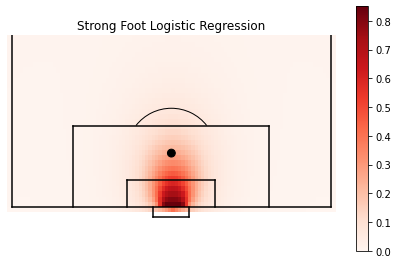

In [25]:
generate_difference_plot(model_1=logistic_regression, params_1={}, plot_title='Strong Foot Logistic Regression')

Next, we'll do the same thing for the Random Forest model

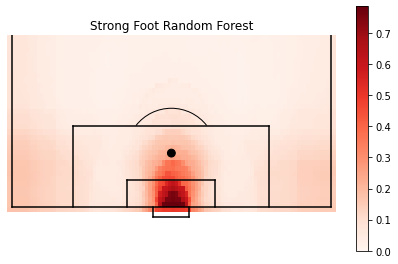

In [26]:
generate_difference_plot(model_1=random_forest_xg_model, params_1={}, 
                         plot_title='Strong Foot Random Forest')

We find that this xG surface is a lot less smooth than the one in the Logistic Regression plot. This matches up with the analysis from Jesse Davis and Pieter Robberechts (https://dtai.cs.kuleuven.be/sports/blog/illustrating-the-interplay-between-features-and-models-in-xg).

This conclusion makes sense, as the Random Forest uses Decision Trees to get the xG surface, thus grouping many points  together and creating clearly defined boundaries. Logistic Regression models, on the other hand, fits a smooth surface as the model is predicting based on a logit-linear combination of the Distance and Angle

Now, let's take a look at the difference between the two models by subtracting their surfaces from one another

Note: In the following plots, the red regions represent area of the pitch where the Random Forest has higher xG, while the blug regions represent regions where the Logistic Regression has higher values

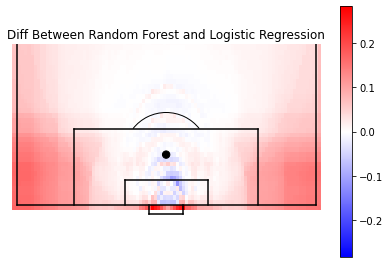

In [27]:
generate_difference_plot(model_1=random_forest_xg_model, 
                         params_1={},
                         model_2=logistic_regression,
                         params_2={},
                         plot_title='Diff Between Random Forest and Logistic Regression')

Well, this is really interesting! In front of the net, the models have very similar outputs, with the Logistic Regression being slightly favored with the best angles. However, we see that the Random Forest has a <b> much </b> greater expected goals value when shots are attempted from the corner. At first glance, that looks horribly wrong (and it likely is), but it's important for us to consider <b> why </b> this has happened, as it gives us great insight into what our model is telling us, and why our intuitive definition for expected goals models does not match up with what this specific model is actually doing.

The reason why the Random Forest is doing this is that the model is effectively calculating the empirical probability of shots taken from similar locations on the pitch. When considering locations in front of the goal, there are many shots to build a model off of, and we are able to obtain realistic estimates. However, there are likely very few shots that were attempted from these locations, and thus our model is overfitting. 

The (obvious) wrong takeaway from this would be to go to a coach and advocate shooting from these locations. It is likely that the shots that were attempted were done so under exceptional circumstances, which is why the empirical probability is so high. Our model is describing what happened in the past, rather than what will happen in the future. More on this in the  conclusion

In the shots in the previous section, we developed a theory that the two models were handling smart passes differently. So, here's the plot!

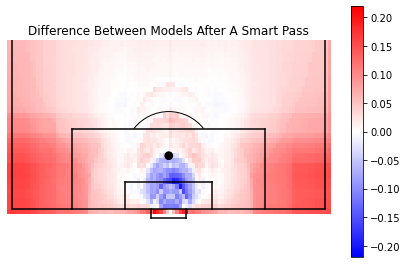

In [28]:
generate_difference_plot(model_1=random_forest_xg_model, 
                         params_1={'prev_smart_pass': 1},
                         model_2=logistic_regression,
                         params_2={'prev_smart_pass': 1},
                         plot_title='Difference Between Models After A Smart Pass')

This plot confirms our theory, as the shots that occur after smart passes have a much high probability right around the 6 yard box (where many of the above shots were taken)

This result is likely the result of an error in our feature selection in Notebook 2. Since we did not interact smart pass with any other variables in the Logistic regression model, it adds the same value on the logit scale to every shot with that tag. Thus, these high probability shots (where the value of the linear predictor is around 0, signifying an xG probability of around .5) see big boosts in their probability due to the shape of the logistic curve. In retrospect, we should have interacted smart pass with both distance  and angle, in order to effecitvely fit a  different surface for these events

In fact, let's compare our logistic regression models with and without the smart pass tagger

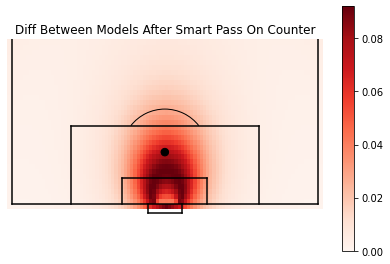

In [29]:
generate_difference_plot(model_1=logistic_regression, 
                         params_1={'prev_smart_pass': 1},
                         model_2=logistic_regression,
                         params_2={},
                         plot_title='Diff Between Models After Smart Pass On Counter')

We find these shots are boosted by close to 10% near the goal, but have little impact elsewhere. This makes sense. However, it is important to note what this is doing to the model. If we remember the Dele Alli and Mo Salah shots from above, they both had this tagger. What the tagger is actually doing is providing us with a proxy for information that we do not have access to (goalkeeper/defender positions, body poses etc.). The reason why this tagger boosts the xG model is that when these events occur, it <b> usually </b> stretches the defense and provides the shooter with more space to shoot. However, this isn't always the case (like with the Dele shot). Thus, this tagger is simply a proxy for stuff that tracking data will tell us

Let's also look at the difference between the two models with both a smart pass and a counter attack (like the Ayoze Perez goal)

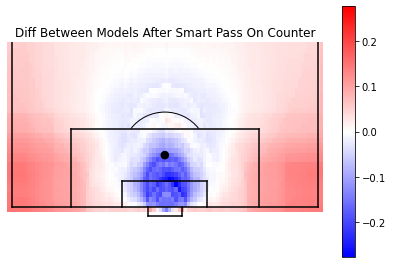

In [30]:
generate_difference_plot(model_1=random_forest_xg_model, 
                         params_1={'prev_smart_pass': 1, 'counter_attack': 1},
                         model_2=logistic_regression,
                         params_2={'prev_smart_pass': 1, 'counter_attack': 1},
                         plot_title='Diff Between Models After Smart Pass On Counter')

We see an even more pronounced version of the effect above

On the Wesley Hoedt and Dwight Gayle chances, we developed a theory that the Random Forest placed a higher weighting on shots that came after a cross, so let's investigate that, first with shots after a cross with the strong foot

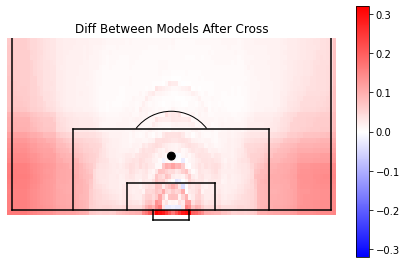

In [31]:
generate_difference_plot(model_1=random_forest_xg_model, 
                         params_1={'prev_cross': 1},
                         model_2=logistic_regression,
                         params_2={'prev_cross': 1},
                         plot_title='Diff Between Models After Cross')

And now with headers after a cross

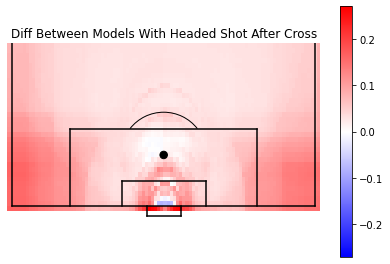

In [32]:
generate_difference_plot(model_1=random_forest_xg_model, 
                         params_1={'prev_cross': 1, 'strong_foot': 0, 'header': 1},
                         model_2=logistic_regression,
                         params_2={'prev_cross': 1, 'strong_foot': 0, 'header': 1},
                         plot_title='Diff Between Models With Headed Shot After Cross')

We find that these plots support our hypothesis.

Finally, I wanted to take a look at how our two models handle stronger vs weaker footed shots, as that will inform one of our takeaways in the  final section

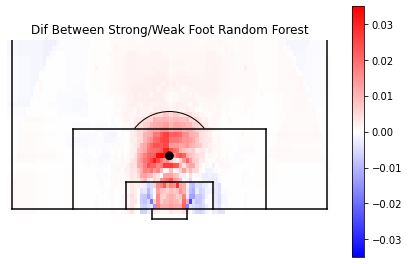

In [33]:
generate_difference_plot(model_1=random_forest_xg_model, 
                         params_1={},
                         model_2=random_forest_xg_model,
                         params_2={'strong_foot': 0},
                         plot_title='Dif Between Strong/Weak Foot Random Forest')

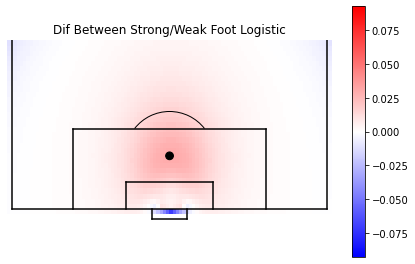

In [34]:
generate_difference_plot(model_1=logistic_regression, 
                         params_1={},
                         model_2=logistic_regression,
                         params_2={'strong_foot': 0},
                         plot_title='Dif Between Strong/Weak Foot Logistic')

We see a much smoother plot (as expected) for the Logistic than for the Random Forest. We also see a couple weird effects, notably that weaker foot shots have a higher xG on the RF model close to goal from weird angles, and that there's some blue far away from goal on the sidelines for the Logistic model

### Final Takeaways

There are a few takeaways to take from this series, and I wanted to highlight them here

#### The way most  people think about expected  goals models is slightly flawed

Most people think about expected goals models in a similar way to how it's defined by fbref:

fbref definition: "xG (or expected goals) is the probability that a shot will result in a goal based on the characteristics of that shot and the events leading up to it" https://fbref.com/en/expected-goals-model-explained/

However, as we explored above, this is not exactly what exepected goals models are representing. Thus, I'd like to propose an alternative definition for this expected goals model:

New definition: The approximate historical frequency of attempted shots leading to goals from similar locations, with similar characteristics and events leading up to it

Ideally, we would like our model to represent the first definition, as that is where it would have the most impact for analyzing to coaches and analyzing games that use out of sample predictions for the xG (as most do). However, our model is accounting the for historical frequency of events with incomplete information, which leads us to be hesitant  of using this model to draw insights

A perfect example of why the incomplete information is a problem is in the comparison between strong and weak footed shots depicted above.

Our model doesn't take into account position of the player, and intuitively it would make sense that strikers had higher xG chances than defenders (like Hoedt in our example above). It is also intuitive that higher percentage of shots with the weak foot are taken by strikers, compared to the percentage of strong foot shots taken by strikers. Thus, our weak footed shots will have artifically higher xG because the historical frequency of shots (and thus percentage of successful shots) is skewed towards strikers. Thus, we see a much smaller difference in xG between strong and weak footed shots as a result.

Thus, we need some form of prior knowledge to avoid overfitting our xG models in regions where we have little data to build a model. Fortunately, David Sumpter has some good suggestions for this, most notably adding "fake data in places where it's unlikely to score." Doing this would help get more reliable estimates in those weird spots where the data is overfit.

#### Our expected goals models are only as good as our data and our additional features are only proxies

As shown by the videos above, our expected goals models suffer from not having complete information about the situation on the field at the time the shot was taken. The following are examples of features that we would like to have, but do not in the dataset used to build  this expected goals model.

1.) Position of goalkeeper <br>
2.) Position of other player <br> 
3.) Body pose of the shooting player <br>
4.) Ability/position of shooting player <br>
and countless others

We try to account for some of this missing information through the use of <b> proxies </b>. On counter attacks, there is often more space for players to exploit, and thus our expected goals model reflects this by boosting the chances on counter attacks. 

This leaves the opportunity for these models to be misinterpreted by taking the output too literally. Thus, we need  to understand our model's outputs and know where we are incorporating information properly

N.B. I know the StatsBomb data contains some of this information. However, the public StatsBomb data is heavily biased by Messi shots as most of the data is from matches he played, so I decided to go with the dataset that

#### Open sourcing is the way to go

This was my first time building an expected goals model, either publicly or privately. As a result, I made many mistakes during the process. However, by open sourcing code, it is easy for others to see and critique your work, and many people in the community have reached out to offer feedback as I've rolled out both this series and my pitch control series. 

Thanks to the Friends of Tracking initiative, the football analytics community has progressed immeasurably in the last 2-3 months, both in size, quality and quantity. A large part of the reason for this is due to open sourcing code. We all have different strengths and weaknesses, and by open sourcing, we help account for other's weaknesses and make it easier for others to publish strong research. On the flip side, you will also benefit from other people's code, and we as a result we all build off of each other instead of everyone reinventing the wheel.

I hope you all enjoyed reading this, and if you have any feedback/suggestions for improvement, please reach out to me on Twitter @andrew_puopolo.